# (a,b) Download/Explore Data
#### Download the data and pick one example from each digit and visualize them. Count the number of samples per digit in the original training data.

x_train:(60000, 784)
y_train:(60000,)
x_test:(10000, 28, 28)	28*28=784


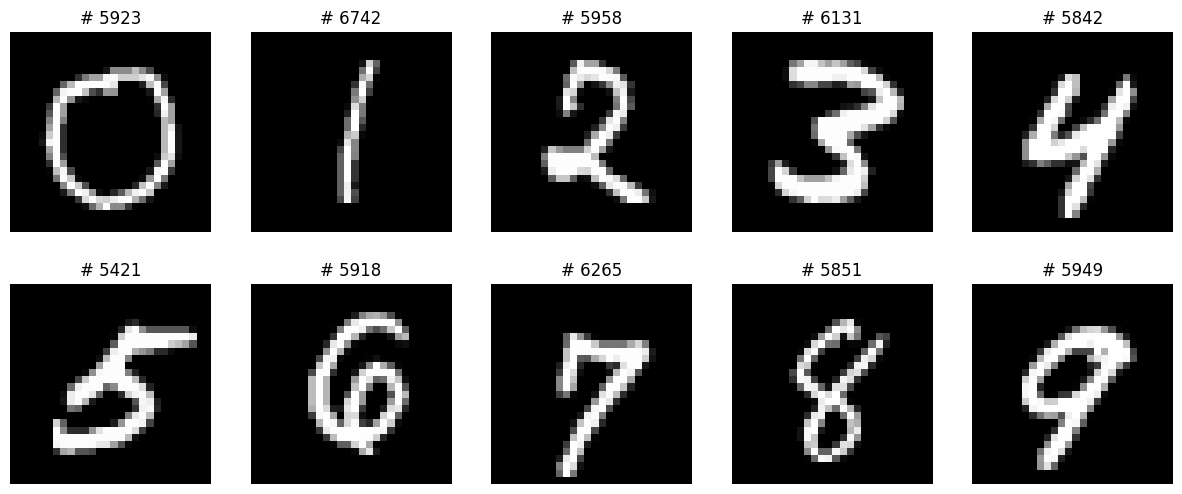

In [2]:
import numpy as np
# print(np.__version__)
import pandas as pd
import random
import matplotlib.pyplot as plt
# import seaborn as sns
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
x_test = np.load('x_test.npy')

print(f'x_train:{x_train.shape}')
print(f'y_train:{y_train.shape}')
print(f'x_test:{x_test.shape}\t28*28=784')

d = dict()
labels = dict(zip(list(range(10)),[0]*10))

for i,l in enumerate(y_train):
    d[int(y_train[i])] = i # index of example
    labels[l]+=1 # label count

fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i,a in enumerate(ax.flat):
    a.imshow(x_train[d[i]].reshape(28,28), cmap='gray')
    a.set_title(f'# {labels[i]}')
    a.axis('off')
plt.show()

# (c) Modeling
#### Implement a Convolutional Neural Network model using Convolution layers to classify the digits in the MNIST dataset.
### (1)
#### Split original training data (60000 datapoints) into training and validation datasets. We also have a test dataset (10000 datapoints).

In [3]:
from sklearn.model_selection import train_test_split
import torch
X,Xv,y,yv = train_test_split(x_train, y_train, test_size=0.2, random_state=777)
print(f'X:{X.shape}, X_v:{Xv.shape}')
from torch.utils.data import DataLoader,TensorDataset
# j,k=torch.from_numpy(X),torch.from_numpy(y)
train_dataloader = DataLoader(TensorDataset(torch.from_numpy(X.reshape(X.shape[0],1,28,28)).float(),torch.from_numpy(y).long()),
                                batch_size=64,shuffle=True)
valid_dataloader = DataLoader(TensorDataset(torch.from_numpy(Xv.reshape(Xv.shape[0],1,28,28)).float(),torch.from_numpy(yv).long()),
                                batch_size=64,shuffle=True)

X:(48000, 784), X_v:(12000, 784)


### (2)
#### Visualize the filter in each layer.

In [84]:
import torch.nn as nn

class cnn_block(nn.Module): # week 11 discussion code, but with 1 in_channel for our grayscale 28x28 images
  def __init__(self, in_channels, n_hidden, kernel_size, stride):
    pad = 'same' if stride[0]==1 else int((27*stride[0]-28+kernel_size[0])/2) # i/o filter formula solving for padding (we have to use safe kernel sizes for this calculation)
    print(f'pad:{pad}\tstride:{stride[0]},kern:{kernel_size[0]}')
    super().__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(in_channels = in_channels, out_channels = n_hidden, kernel_size = kernel_size, bias=False, padding = pad, stride = stride),
        nn.BatchNorm2d(num_features = n_hidden),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Conv2d(in_channels = n_hidden, out_channels = in_channels, kernel_size = kernel_size, bias=False, padding = pad, stride = stride),
        nn.BatchNorm2d(num_features = in_channels),
        nn.ReLU(),
        nn.Dropout(p=0.2))

  def forward(self, x):
    return x + self.layers(x)

class linear_block(nn.Module):
  def __init__(self, in_features, n_hidden):
    super().__init__()
    self.in_features = (in_features, n_hidden)
    self.layers = nn.Sequential(
        nn.Linear(in_features = in_features, out_features = n_hidden),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(in_features = n_hidden, out_features = in_features),
        nn.ReLU()
    )

  def forward(self, x):
    return x + self.layers(x)

class CNNClassifier(nn.Module):
  def __init__(self, in_channels = 3, cnn_channels = 5, linear_hidden = 1000, n_classes = 10, kernel_size = (3, 3), stride = (1, 1)):
    super().__init__()
    self.cnn_layers = nn.Sequential(
        cnn_block(in_channels, cnn_channels, kernel_size, stride=stride),
        cnn_block(in_channels, cnn_channels, kernel_size, stride=stride),
        cnn_block(in_channels, cnn_channels, kernel_size, stride=stride))

    self.down_sample = nn.Conv2d(in_channels = in_channels, out_channels = 1, kernel_size = (1, 1))

    self.linear_layers = nn.Sequential(
        linear_block(28*28, linear_hidden),
        linear_block(28*28, linear_hidden)
    )
    self.last_layer = nn.Linear(28*28, n_classes)

    self.all        = nn.Sequential(
        self.cnn_layers,
        self.down_sample,
        nn.Flatten(),
        self.linear_layers,
        self.last_layer,
    )

  def forward(self, x):
    return self.all(x)
  

from torch.optim import Adam
device    = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')
model     = CNNClassifier(in_channels = 1, cnn_channels = 8, linear_hidden = 10, n_classes = 10, kernel_size = (4, 4)).to(device)
loss_fn   = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = 1e-3)

from tqdm import tqdm
n_epochs = 50
train_loss, test_loss = [], []
for epoch in tqdm(range(n_epochs)):
    # do a loop over all training samples
    model.train() # telling the model we are training it as it needs to keep track of gradients (and other things) in this modality
    epoch_train_loss = []
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        preds = model(X)
        loss = loss_fn(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss.append(loss.item())
    # do a loop over all testing samples
    model.eval() # telling the model we are evaluating it
    epoch_test_loss = []
    with torch.no_grad(): # alternatively, torch.no_grad()
        for batch, (X, y) in enumerate(valid_dataloader):
            X, y = X.to(device), y.to(device)
            preds = model(X)
            loss  = loss_fn(preds, y)
            epoch_test_loss.append(loss.item())
    train_loss.append(np.mean(epoch_train_loss))
    test_loss.append(np.mean(epoch_test_loss))


Device: cuda
pad:same	stride:1,kern:4
pad:same	stride:1,kern:4
pad:same	stride:1,kern:4


100%|██████████| 50/50 [03:59<00:00,  4.79s/it]


Layer:0
Conv 0


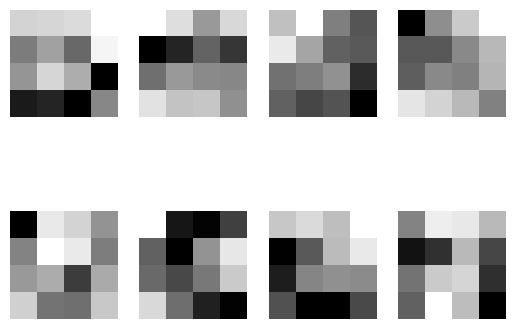

Conv 1


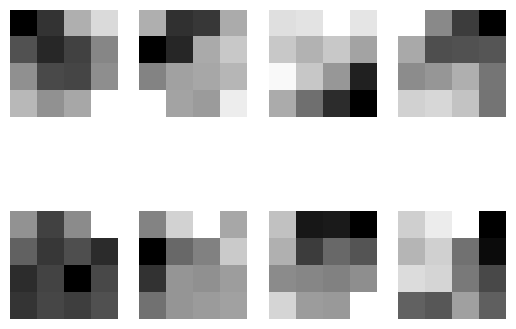

Layer:1
Conv 0


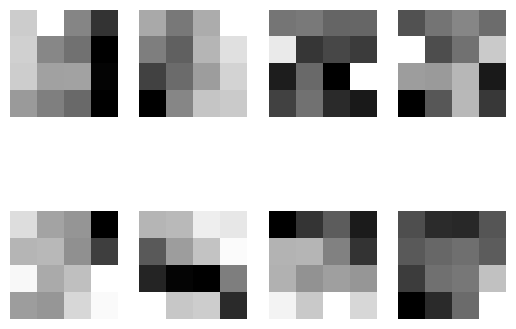

Conv 1


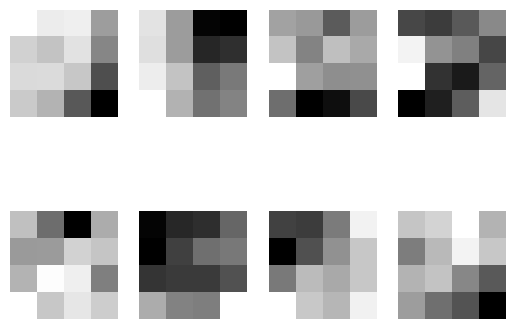

Layer:2
Conv 0


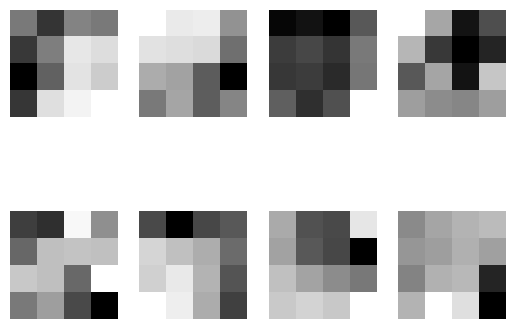

Conv 1


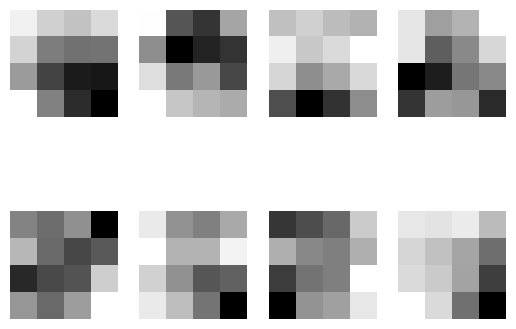

In [85]:
# print(model.cnn_layers[0])
# print(model.last_layer)
# for param in model.named_parameters():
#     print(param)
# print(model.cnn_layers[0])

# fig,axs = plt.subplots()
# print(f'cnn[{i}].layers[{j}].weight {model.cnn_layers[i].layers[j].weight.detach().numpy().shape}')
for j in range(3):
    print(f'Layer:{j}')
    print('Conv 0')
    fig,axs = plt.subplots(2,4)
    for i,ax in enumerate(axs.flat):
        ax.imshow(model.cnn_layers[j].layers[0].weight[i,0,:,:].cpu().detach().numpy(),cmap='gray')
        ax.axis('off')
    plt.show()

    print('Conv 1')
    fig,axs = plt.subplots(2,4)
    for i,ax in enumerate(axs.flat):
        ax.imshow(model.cnn_layers[j].layers[4].weight[0,i,:,:].cpu().detach().numpy(),cmap='gray')
        ax.axis('off')
    plt.show()

### (3)
#### Monitor the loss on the training dataset across the epochs of the CNN training. Report the overall classification accuracy on validation dataset.

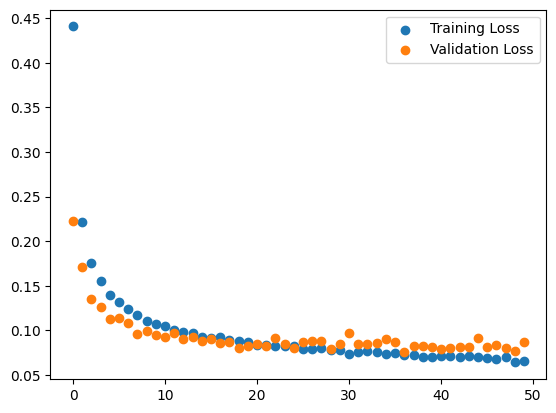

In [88]:
plt.scatter(range(n_epochs),train_loss, label='Training Loss')
plt.scatter(range(n_epochs),test_loss, label='Validation Loss')
plt.legend()
plt.show()

As the model learns on the training set it gets better at predicting on the validation set. If we continue training, the model will overfit to the training set and the validation loss will start to increase.

### (4) 
#### Use validation dataset to tune the hyper-parameters of the model. You may experimenton the validation set with different CNN hyper-parameters, e.g. num of layers, filter size, stride, activation function, dropout, weight regularization, etc. You may also try different loss functions and optimization methods.

In [75]:
def train(lr,cnn_channels,kernel_size,stride,n_epochs):
    model     = CNNClassifier(in_channels = 1, cnn_channels=cnn_channels, linear_hidden=10, n_classes=10, kernel_size=kernel_size, stride=stride).to(device)
    loss_fn   = nn.CrossEntropyLoss() # I trust cross entropy loss
    optimizer = Adam(model.parameters(), lr = lr) # I trust Adam

    train_loss, test_loss = [], []
    for epoch in tqdm(range(n_epochs)):
        # do a loop over all training samples
        model.train() # telling the model we are training it as it needs to keep track of gradients (and other things) in this modality
        epoch_train_loss = []
        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            preds = model(X)
            loss = loss_fn(preds, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss.append(loss.item())
        # do a loop over all testing samples
        model.eval() # telling the model we are evaluating it
        epoch_test_loss = []
        with torch.no_grad(): # alternatively, torch.no_grad()
            for batch, (X, y) in enumerate(valid_dataloader):
                X, y = X.to(device), y.to(device)
                preds = model(X)
                loss  = loss_fn(preds, y)
                epoch_test_loss.append(loss.item())
        train_loss.append(np.mean(epoch_train_loss))
        test_loss.append(np.mean(epoch_test_loss))
    return model,test_loss


In [76]:

# (in_channels = 3, cnn_channels = 5, linear_hidden = 1000, n_classes = 10, kernel_size = (3, 3))
params = {
    'lr':[1e-3,1e-2],
    'cnn_channels': [6,8,10],
    'kernel_size': [(3,3),(4,4),(5,5),(6,6)],
    'stride': [(1,1),(2,2),(3,3)]
} # I trust ReLU since we are concerned with the activated pixels
D = { # top 3 scores from search
    0:{
        'score':1,
        'test_loss':None,
        'params':None,
    },
    1:{
        'score':1,
        'test_loss':None,
        'params':None,
    },
    2:{
        'score':1,
        'test_loss':None,
        'params':None,
    }
}

import copy
def eval(loss,lr,cnn_channels,kernel_size,stride,model):
    score = np.array(loss[-5:]).mean()
    print(f'\tscore:{score}')
    if score<D[0]['score']:
        D[2] = D[1].copy()
        D[1] = D[0].copy()
        D[0] = {'score':score,
                'test_loss':loss,
                'params':{
                    'lr':lr,
                    'cnn_channels':cnn_channels,
                    'kernel_size':kernel_size,
                    'stride':stride},
                'model':copy.deepcopy(model)}
        return
    if score<D[1]['score']:
        D[2] = D[1].copy()
        D[1] = {'score':score,
                'test_loss':loss,
                'params':{
                    'lr':lr,
                    'cnn_channels':cnn_channels,
                    'kernel_size':kernel_size,
                    'stride':stride},
                'model':copy.deepcopy(model)}
        return
    if score<D[2]['score']:
        D[2] = {'score':score,
                'test_loss':loss,
                'params':{
                    'lr':lr,
                    'cnn_channels':cnn_channels,
                    'kernel_size':kernel_size,
                    'stride':stride},
                'model':copy.deepcopy(model)}
        return
# constant stride=1x1
for lr in params['lr']:
    for cnn_channels in params['cnn_channels']:
        for kernel_size in params['kernel_size']:
            print(f'lr:{lr},cnn:{cnn_channels},kernel:{kernel_size},stride:{(1,1)}',end='')
            model,test_loss = train(lr,cnn_channels,kernel_size,(1,1),40) # 40 epochs is enough for training & analyzing
            eval(test_loss,lr,cnn_channels,kernel_size,(1,1),model)


lr:0.001,cnn:6,kernel:(3, 3),stride:(1, 1)pad:same	stride:1,kern:3
pad:same	stride:1,kern:3
pad:same	stride:1,kern:3


100%|██████████| 40/40 [03:02<00:00,  4.56s/it]


	score:0.1062226624267691
lr:0.001,cnn:6,kernel:(4, 4),stride:(1, 1)pad:same	stride:1,kern:4
pad:same	stride:1,kern:4
pad:same	stride:1,kern:4


100%|██████████| 40/40 [03:16<00:00,  4.92s/it]


	score:0.0791392844237209
lr:0.001,cnn:6,kernel:(5, 5),stride:(1, 1)pad:same	stride:1,kern:5
pad:same	stride:1,kern:5
pad:same	stride:1,kern:5


100%|██████████| 40/40 [03:00<00:00,  4.52s/it]


	score:0.07458101355128902
lr:0.001,cnn:6,kernel:(6, 6),stride:(1, 1)pad:same	stride:1,kern:6
pad:same	stride:1,kern:6
pad:same	stride:1,kern:6


100%|██████████| 40/40 [03:23<00:00,  5.08s/it]


	score:0.07044998285486956
lr:0.001,cnn:8,kernel:(3, 3),stride:(1, 1)pad:same	stride:1,kern:3
pad:same	stride:1,kern:3
pad:same	stride:1,kern:3


100%|██████████| 40/40 [03:07<00:00,  4.68s/it]


	score:0.10834396011097
lr:0.001,cnn:8,kernel:(4, 4),stride:(1, 1)pad:same	stride:1,kern:4
pad:same	stride:1,kern:4
pad:same	stride:1,kern:4


100%|██████████| 40/40 [03:12<00:00,  4.81s/it]


	score:0.0981692358086064
lr:0.001,cnn:8,kernel:(5, 5),stride:(1, 1)pad:same	stride:1,kern:5
pad:same	stride:1,kern:5
pad:same	stride:1,kern:5


100%|██████████| 40/40 [03:05<00:00,  4.64s/it]


	score:0.07131321178006127
lr:0.001,cnn:8,kernel:(6, 6),stride:(1, 1)pad:same	stride:1,kern:6
pad:same	stride:1,kern:6
pad:same	stride:1,kern:6


100%|██████████| 40/40 [03:25<00:00,  5.14s/it]


	score:0.06283799567906326
lr:0.001,cnn:10,kernel:(3, 3),stride:(1, 1)pad:same	stride:1,kern:3
pad:same	stride:1,kern:3
pad:same	stride:1,kern:3


100%|██████████| 40/40 [03:05<00:00,  4.63s/it]


	score:0.11977387430007629
lr:0.001,cnn:10,kernel:(4, 4),stride:(1, 1)pad:same	stride:1,kern:4
pad:same	stride:1,kern:4
pad:same	stride:1,kern:4


100%|██████████| 40/40 [03:11<00:00,  4.78s/it]


	score:0.09389054432023376
lr:0.001,cnn:10,kernel:(5, 5),stride:(1, 1)pad:same	stride:1,kern:5
pad:same	stride:1,kern:5
pad:same	stride:1,kern:5


100%|██████████| 40/40 [03:03<00:00,  4.59s/it]


	score:0.07120530576757254
lr:0.001,cnn:10,kernel:(6, 6),stride:(1, 1)pad:same	stride:1,kern:6
pad:same	stride:1,kern:6
pad:same	stride:1,kern:6


100%|██████████| 40/40 [03:27<00:00,  5.19s/it]


	score:0.05796316850780599
lr:0.01,cnn:6,kernel:(3, 3),stride:(1, 1)pad:same	stride:1,kern:3
pad:same	stride:1,kern:3
pad:same	stride:1,kern:3


100%|██████████| 40/40 [03:00<00:00,  4.51s/it]


	score:0.20630140181908266
lr:0.01,cnn:6,kernel:(4, 4),stride:(1, 1)pad:same	stride:1,kern:4
pad:same	stride:1,kern:4
pad:same	stride:1,kern:4


100%|██████████| 40/40 [03:11<00:00,  4.79s/it]


	score:0.1529306035704336
lr:0.01,cnn:6,kernel:(5, 5),stride:(1, 1)pad:same	stride:1,kern:5
pad:same	stride:1,kern:5
pad:same	stride:1,kern:5


100%|██████████| 40/40 [02:57<00:00,  4.44s/it]


	score:0.12169898528646879
lr:0.01,cnn:6,kernel:(6, 6),stride:(1, 1)pad:same	stride:1,kern:6
pad:same	stride:1,kern:6
pad:same	stride:1,kern:6


100%|██████████| 40/40 [03:17<00:00,  4.95s/it]


	score:0.16883490976104715
lr:0.01,cnn:8,kernel:(3, 3),stride:(1, 1)pad:same	stride:1,kern:3
pad:same	stride:1,kern:3
pad:same	stride:1,kern:3


100%|██████████| 40/40 [03:07<00:00,  4.69s/it]


	score:0.1649525172651765
lr:0.01,cnn:8,kernel:(4, 4),stride:(1, 1)pad:same	stride:1,kern:4
pad:same	stride:1,kern:4
pad:same	stride:1,kern:4


100%|██████████| 40/40 [03:12<00:00,  4.82s/it]


	score:0.09762794356248242
lr:0.01,cnn:8,kernel:(5, 5),stride:(1, 1)pad:same	stride:1,kern:5
pad:same	stride:1,kern:5
pad:same	stride:1,kern:5


100%|██████████| 40/40 [03:08<00:00,  4.72s/it]


	score:0.12283721327524078
lr:0.01,cnn:8,kernel:(6, 6),stride:(1, 1)pad:same	stride:1,kern:6
pad:same	stride:1,kern:6
pad:same	stride:1,kern:6


100%|██████████| 40/40 [03:29<00:00,  5.24s/it]


	score:0.08940631852117106
lr:0.01,cnn:10,kernel:(3, 3),stride:(1, 1)pad:same	stride:1,kern:3
pad:same	stride:1,kern:3
pad:same	stride:1,kern:3


100%|██████████| 40/40 [03:07<00:00,  4.69s/it]


	score:0.1616697078560816
lr:0.01,cnn:10,kernel:(4, 4),stride:(1, 1)pad:same	stride:1,kern:4
pad:same	stride:1,kern:4
pad:same	stride:1,kern:4


100%|██████████| 40/40 [03:15<00:00,  4.89s/it]


	score:0.14064901333668842
lr:0.01,cnn:10,kernel:(5, 5),stride:(1, 1)pad:same	stride:1,kern:5
pad:same	stride:1,kern:5
pad:same	stride:1,kern:5


100%|██████████| 40/40 [03:07<00:00,  4.68s/it]


	score:0.1452495333136733
lr:0.01,cnn:10,kernel:(6, 6),stride:(1, 1)pad:same	stride:1,kern:6
pad:same	stride:1,kern:6
pad:same	stride:1,kern:6


100%|██████████| 40/40 [03:33<00:00,  5.35s/it]

	score:0.061753392636657065


In [77]:
# constant kernel=4x4
for lr in params['lr']:
    for cnn_channels in params['cnn_channels']:
        for stride in params['stride']:
            kernel_size = (5,5) if stride[0]==3 else (4,4)
            print(f'lr:{lr},cnn:{cnn_channels},kernel:{kernel_size},stride:{stride}',end='')
            model,test_loss = train(lr,cnn_channels,kernel_size,stride,40) # 40 epochs is enough for training & analyzing
            eval(test_loss,lr,cnn_channels,kernel_size,stride,model)

lr:0.001,cnn:6,kernel:(4, 4),stride:(1, 1)pad:same	stride:1,kern:4
pad:same	stride:1,kern:4
pad:same	stride:1,kern:4


100%|██████████| 40/40 [03:18<00:00,  4.96s/it]


	score:0.07943041381163603
lr:0.001,cnn:6,kernel:(4, 4),stride:(2, 2)pad:15	stride:2,kern:4
pad:15	stride:2,kern:4
pad:15	stride:2,kern:4


100%|██████████| 40/40 [02:58<00:00,  4.45s/it]


	score:0.09656232578774043
lr:0.001,cnn:6,kernel:(5, 5),stride:(3, 3)pad:29	stride:3,kern:5
pad:29	stride:3,kern:5
pad:29	stride:3,kern:5


100%|██████████| 40/40 [02:58<00:00,  4.46s/it]


	score:0.11258294591259092
lr:0.001,cnn:8,kernel:(4, 4),stride:(1, 1)pad:same	stride:1,kern:4
pad:same	stride:1,kern:4
pad:same	stride:1,kern:4


100%|██████████| 40/40 [03:15<00:00,  4.90s/it]


	score:0.09269564709244693
lr:0.001,cnn:8,kernel:(4, 4),stride:(2, 2)pad:15	stride:2,kern:4
pad:15	stride:2,kern:4
pad:15	stride:2,kern:4


100%|██████████| 40/40 [02:58<00:00,  4.47s/it]


	score:0.1043560358601563
lr:0.001,cnn:8,kernel:(5, 5),stride:(3, 3)pad:29	stride:3,kern:5
pad:29	stride:3,kern:5
pad:29	stride:3,kern:5


100%|██████████| 40/40 [02:54<00:00,  4.37s/it]


	score:0.12557191302767023
lr:0.001,cnn:10,kernel:(4, 4),stride:(1, 1)pad:same	stride:1,kern:4
pad:same	stride:1,kern:4
pad:same	stride:1,kern:4


100%|██████████| 40/40 [03:11<00:00,  4.80s/it]


	score:0.08114216502141604
lr:0.001,cnn:10,kernel:(4, 4),stride:(2, 2)pad:15	stride:2,kern:4
pad:15	stride:2,kern:4
pad:15	stride:2,kern:4


100%|██████████| 40/40 [02:54<00:00,  4.37s/it]


	score:0.10118808970350694
lr:0.001,cnn:10,kernel:(5, 5),stride:(3, 3)pad:29	stride:3,kern:5
pad:29	stride:3,kern:5
pad:29	stride:3,kern:5


100%|██████████| 40/40 [02:56<00:00,  4.40s/it]


	score:0.11548691643835443
lr:0.01,cnn:6,kernel:(4, 4),stride:(1, 1)pad:same	stride:1,kern:4
pad:same	stride:1,kern:4
pad:same	stride:1,kern:4


100%|██████████| 40/40 [03:12<00:00,  4.82s/it]


	score:0.1018004391986401
lr:0.01,cnn:6,kernel:(4, 4),stride:(2, 2)pad:15	stride:2,kern:4
pad:15	stride:2,kern:4
pad:15	stride:2,kern:4


100%|██████████| 40/40 [02:54<00:00,  4.35s/it]


	score:0.144493188544553
lr:0.01,cnn:6,kernel:(5, 5),stride:(3, 3)pad:29	stride:3,kern:5
pad:29	stride:3,kern:5
pad:29	stride:3,kern:5


100%|██████████| 40/40 [02:54<00:00,  4.36s/it]


	score:0.16719909558132134
lr:0.01,cnn:8,kernel:(4, 4),stride:(1, 1)pad:same	stride:1,kern:4
pad:same	stride:1,kern:4
pad:same	stride:1,kern:4


100%|██████████| 40/40 [03:12<00:00,  4.82s/it]


	score:0.10081060175892917
lr:0.01,cnn:8,kernel:(4, 4),stride:(2, 2)pad:15	stride:2,kern:4
pad:15	stride:2,kern:4
pad:15	stride:2,kern:4


100%|██████████| 40/40 [02:54<00:00,  4.37s/it]


	score:0.17792260739754173
lr:0.01,cnn:8,kernel:(5, 5),stride:(3, 3)pad:29	stride:3,kern:5
pad:29	stride:3,kern:5
pad:29	stride:3,kern:5


100%|██████████| 40/40 [02:54<00:00,  4.36s/it]


	score:0.25702436686632163
lr:0.01,cnn:10,kernel:(4, 4),stride:(1, 1)pad:same	stride:1,kern:4
pad:same	stride:1,kern:4
pad:same	stride:1,kern:4


100%|██████████| 40/40 [03:16<00:00,  4.91s/it]


	score:0.16544488647360073
lr:0.01,cnn:10,kernel:(4, 4),stride:(2, 2)pad:15	stride:2,kern:4
pad:15	stride:2,kern:4
pad:15	stride:2,kern:4


100%|██████████| 40/40 [02:59<00:00,  4.49s/it]


	score:0.21762175314881382
lr:0.01,cnn:10,kernel:(5, 5),stride:(3, 3)pad:29	stride:3,kern:5
pad:29	stride:3,kern:5
pad:29	stride:3,kern:5


100%|██████████| 40/40 [03:00<00:00,  4.52s/it]

	score:0.1472573704472644


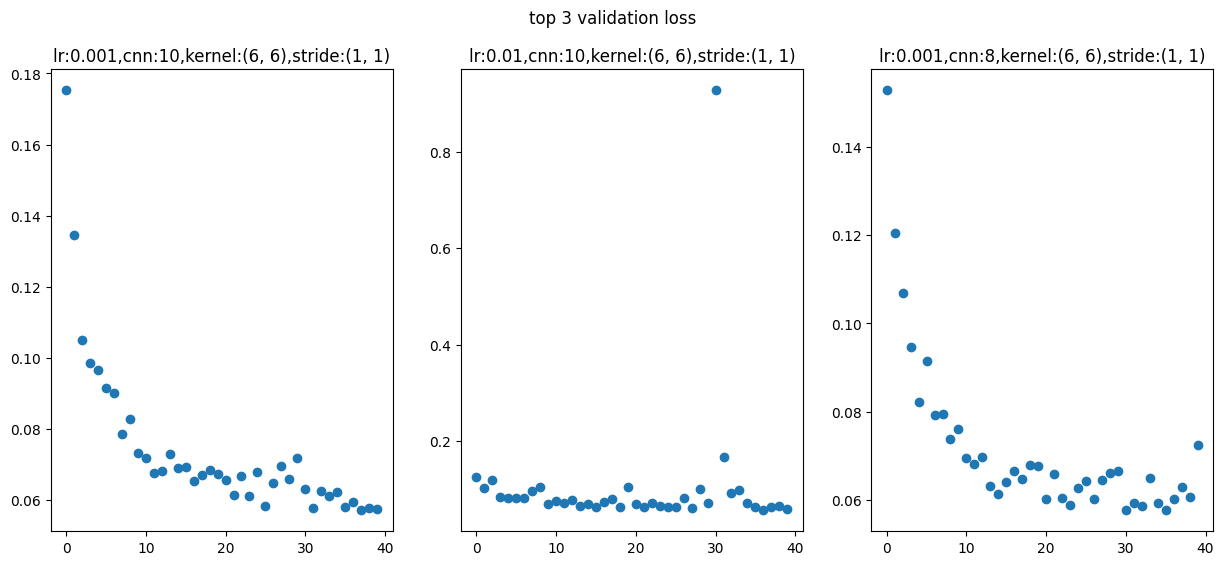

first layer filters


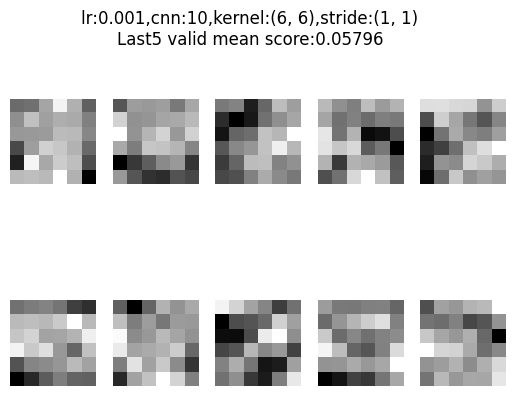

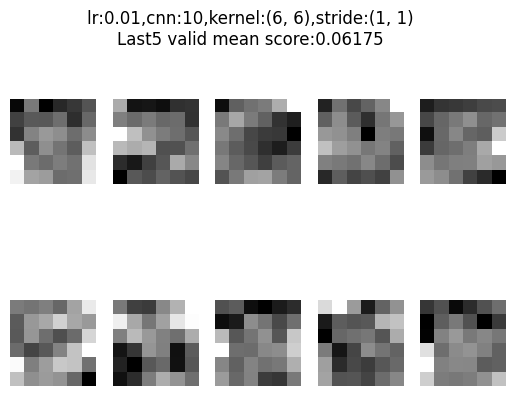

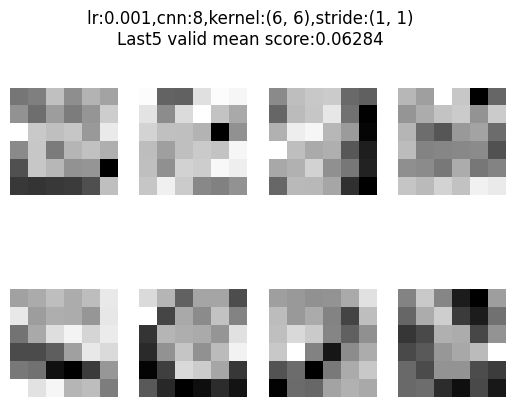

In [78]:
fig, axs = plt.subplots(1,3,figsize=(15, 6))
for i,a in enumerate(axs.flat):
    a.scatter(range(len(D[i]['test_loss'])),D[i]['test_loss'])
    a.set_title(f'lr:{D[i]['params']['lr']},cnn:{D[i]['params']['cnn_channels']},kernel:{D[i]['params']['kernel_size']},stride:{D[i]['params']['stride']}')
fig.suptitle('top 3 validation loss')
plt.show()

print('first layer filters')
for i in range(3):
    fig, axs = plt.subplots(2,int(D[i]['params']['cnn_channels']/2))
    for j,a in enumerate(axs.flat):
        a.imshow(D[i]['model'].cnn_layers[0].layers[0].weight[j,0,:,:].cpu().detach().numpy(),cmap='gray')
        a.axis('off')
    fig.suptitle(f'lr:{D[i]['params']['lr']},cnn:{D[i]['params']['cnn_channels']},kernel:{D[i]['params']['kernel_size']},stride:{D[i]['params']['stride']}\nLast5 valid mean score:{(round(D[i]['score'],5))}')
    plt.show()

# (5)
#### Use the best fine-tuned model for inference on test dataset. Compare the classification accuracy with the model you had in step 3 above.

pad:same	stride:1,kern:6
pad:same	stride:1,kern:6
pad:same	stride:1,kern:6


100%|██████████| 75/75 [06:48<00:00,  5.44s/it]


pad:16	stride:2,kern:6
pad:16	stride:2,kern:6
pad:16	stride:2,kern:6


100%|██████████| 75/75 [06:46<00:00,  5.42s/it]


pad:43	stride:4,kern:6
pad:43	stride:4,kern:6
pad:43	stride:4,kern:6


100%|██████████| 75/75 [06:34<00:00,  5.26s/it]


pad:30	stride:3,kern:7
pad:30	stride:3,kern:7
pad:30	stride:3,kern:7


100%|██████████| 75/75 [06:58<00:00,  5.59s/it]


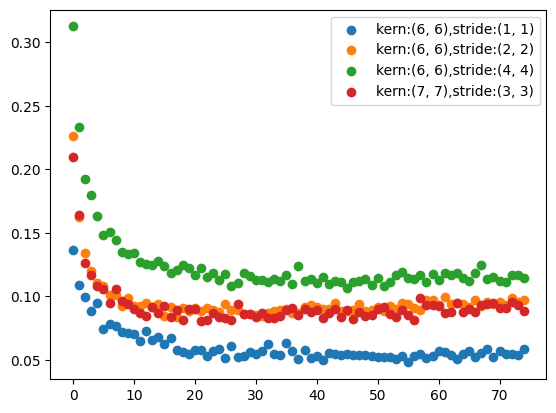

In [149]:
_,loss0 = train(lr=0.001,cnn_channels=10,kernel_size=(6,6),stride=(1,1),n_epochs=75)
_,loss1 = train(lr=0.001,cnn_channels=10,kernel_size=(6,6),stride=(2,2),n_epochs=75)
_,loss2 = train(lr=0.001,cnn_channels=10,kernel_size=(6,6),stride=(4,4),n_epochs=75)
_,loss3 = train(lr=0.001,cnn_channels=10,kernel_size=(7,7),stride=(3,3),n_epochs=75)

plt.scatter(range(75),loss0,label=f'kern:{(6,6)},stride:{(1,1)}')
plt.scatter(range(75),loss1,label=f'kern:{(6,6)},stride:{(2,2)}')
plt.scatter(range(75),loss2,label=f'kern:{(6,6)},stride:{(4,4)}')
plt.scatter(range(75),loss3,label=f'kern:{(7,7)},stride:{(3,3)}')
plt.legend()
plt.show()

pad:same	stride:1,kern:6
pad:same	stride:1,kern:6
pad:same	stride:1,kern:6


100%|██████████| 60/60 [05:28<00:00,  5.47s/it]

0.05834796044088782


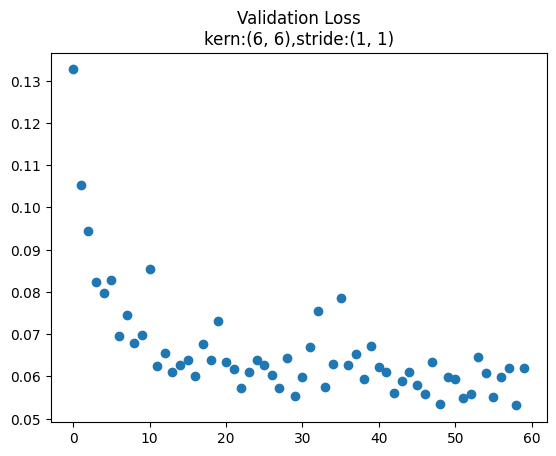

In [150]:
model,loss = train(lr=0.001,cnn_channels=10,kernel_size=(6,6),stride=(1,1),n_epochs=60)
print(np.array(loss[-5:]).mean())
plt.scatter(range(60),loss)
plt.title(f'Validation Loss\nkern:{(6,6)},stride:{(1,1)}')
plt.show()

test_dataloader = DataLoader(TensorDataset(torch.from_numpy(x_test.reshape(x_test.shape[0],1,28,28)).float()), batch_size=64, shuffle=False)
model.eval()
preds = list()
with torch.no_grad():
        for batch, X in enumerate(test_dataloader):
            X = X[0].cpu().to(device)
            pred_batch = model(X)
            for dist in pred_batch:
                preds.append(int(dist.argmax()))
pd.Series(preds, name=None).to_csv('Nicholas_Garde_preds.csv',index=False,header=False)

##### My tuned model's accuracy was much better than my initial model. I was surprised to find out increasing stride length only worsened accuracy. It makes sense on larger kernels since the relevant pixels are grouped in the middle, increasing stride observes less patterns rather than detailed observations all around the group. In the extra credit I plan to tune network depth.

##### ...unfortunately I did not have enough time this week for the extra credit



In [151]:
# print(model.linear_layers[0].layers[5].bias.detach().numpy().shape)

# for param in model.named_parameters():
#     print(str(param))

# for i in model.cnn_layers:
#     for j in i.layers:
#         print(f'{type(j)}')
        # if type(j)!='ReLU':
        #     print(j.weight.detach().numpy().shape)

# for i in D.keys():
#     print(D[i])

# for batch, (X,y) in enumerate(valid_dataloader):
#     print(X.shape)
# torch.Size([64,1,28,28])

# test_dataloader = DataLoader(TensorDataset(torch.from_numpy(x_test.reshape(x_test.shape[0],1,28,28)).float()), batch_size=64)
# for batch, X in enumerate(test_dataloader):
#         print(X[0].shape)

# for i,X in enumerate(x_test):
#     plt.imshow(X,cmap='gray')
#     plt.show()
#     if i>4:break